## Without ARM

In [61]:
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
urdf_root_path = '/home/Go2py/Go2Py/assets'
urdf_path = '/home/Go2py/Go2Py/assets/urdf/go2_reordered.urdf'
robot = pin.RobotWrapper.BuildFromURDF(
urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

ValueError: Mesh dae/base.dae could not be found.

In [62]:
import sys
import mim_solvers
pinRef        = pin.LOCAL_WORLD_ALIGNED
FRICTION_CSTR = True
MU = 0.8     # friction coefficient

In [28]:
ee_frame_names = ['FL_foot', 'FR_foot', 'RL_foot', 'RR_foot']
rmodel = robot.model
rdata = robot.data
# # set contact frame_names and_indices
lfFootId = rmodel.getFrameId(ee_frame_names[0])
rfFootId = rmodel.getFrameId(ee_frame_names[1])
lhFootId = rmodel.getFrameId(ee_frame_names[2])
rhFootId = rmodel.getFrameId(ee_frame_names[3])

In [29]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

In [30]:
pinocchio.forwardKinematics(rmodel, rdata, q0)
pinocchio.updateFramePlacements(rmodel, rdata)
rfFootPos0 = rdata.oMf[rfFootId].translation
rhFootPos0 = rdata.oMf[rhFootId].translation
lfFootPos0 = rdata.oMf[lfFootId].translation
lhFootPos0 = rdata.oMf[lhFootId].translation 

In [34]:
comRef = (rfFootPos0 + rhFootPos0 + lfFootPos0 + lhFootPos0) / 4
comRef[2] = pinocchio.centerOfMass(rmodel, rdata, q0)[2].item() 
print(f'The desired CoM position is: {comRef}')

The desired CoM position is: [0.00060515 0.         0.27853327]


In [35]:
supportFeetIds = [lfFootId, rfFootId, lhFootId, rhFootId]
supportFeePos = [lfFootPos0, rfFootPos0, lhFootPos0, rhFootPos0]

In [36]:
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
nu = actuation.nu

In [37]:
comDes = []

N_ocp = 250 #100
dt = 0.02
T = N_ocp * dt
radius = 0.065
for t in range(N_ocp+1):
    comDes_t = comRef.copy()
    w = (2 * np.pi) * 0.2 # / T
    comDes_t[0] += radius * np.sin(w * t * dt) 
    comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
    comDes += [comDes_t]

In [38]:
import friction_utils
running_models = []
constraintModels = []

for t in range(N_ocp+1):
    contactModel = crocoddyl.ContactModelMultiple(state, nu)
    costModel = crocoddyl.CostModelSum(state, nu)

    # Add contact
    for frame_idx in supportFeetIds:
        support_contact = crocoddyl.ContactModel3D(state, frame_idx, np.array([0., 0., 0.]), pinRef, nu, np.array([0., 0.]))
        # print("contact name = ", rmodel.frames[frame_idx].name + "_contact")
        contactModel.addContact(rmodel.frames[frame_idx].name + "_contact", support_contact) 

    # Add state/control reg costs

    state_reg_weight, control_reg_weight = 1e-1, 1e-3

    freeFlyerQWeight = [0.]*3 + [500.]*3
    freeFlyerVWeight = [10.]*6
    legsQWeight = [0.01]*(rmodel.nv - 6)
    legsWWeights = [1.]*(rmodel.nv - 6)
    stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    


    stateResidual = crocoddyl.ResidualModelState(state, x0, nu)
    stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
    stateReg = crocoddyl.CostModelResidual(state, stateActivation, stateResidual)

    if t == N_ocp:
        costModel.addCost("stateReg", stateReg, state_reg_weight*dt)
    else:
        costModel.addCost("stateReg", stateReg, state_reg_weight)

    if t != N_ocp:
        ctrlResidual = crocoddyl.ResidualModelControl(state, nu)
        ctrlReg = crocoddyl.CostModelResidual(state, ctrlResidual)
        costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


    # Add COM task
    com_residual = crocoddyl.ResidualModelCoMPosition(state, comDes[t], nu)
    com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    com_track = crocoddyl.CostModelResidual(state, com_activation, com_residual)
    if t == N_ocp:
        costModel.addCost("comTrack", com_track, 1e5)
    else:
        costModel.addCost("comTrack", com_track, 1e5)

    constraintModelManager = crocoddyl.ConstraintModelManager(state, actuation.nu)
    if(FRICTION_CSTR):
        if(t != N_ocp):
            for frame_idx in supportFeetIds:
                name = rmodel.frames[frame_idx].name + "_contact"
                residualFriction = friction_utils.ResidualFrictionCone(state, name, MU, actuation.nu)
                constraintFriction = crocoddyl.ConstraintModelResidual(state, residualFriction, np.array([0.]), np.array([np.inf]))
                constraintModelManager.addConstraint(name + "friction", constraintFriction)

    dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contactModel, costModel, constraintModelManager, 0., True)
    model = crocoddyl.IntegratedActionModelEuler(dmodel, dt)

    running_models += [model]


In [39]:
# Create shooting problem
ocp = crocoddyl.ShootingProblem(x0, running_models[:-1], running_models[-1])

solver = mim_solvers.SolverCSQP(ocp)
solver.max_qp_iters = 1000
max_iter = 500
solver.with_callbacks = True
solver.use_filter_line_search = False
solver.termination_tolerance = 1e-4
solver.eps_abs = 1e-6
solver.eps_rel = 1e-6

In [40]:
xs = [x0]*(solver.problem.T + 1)
us = solver.problem.quasiStatic([x0]*solver.problem.T) 
solver.solve(xs, us, max_iter)   

True

In [41]:
nq, nv, N = rmodel.nq, rmodel.nv, len(xs) 
jointPos_sol = []
jointVel_sol = []
jointAcc_sol = []
jointTorques_sol = []
centroidal_sol = []
xs, us = solver.xs, solver.us
x = []
for time_idx in range (N):
    q, v = xs[time_idx][:nq], xs[time_idx][nq:]
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.computeCentroidalMomentum(rmodel, rdata, q, v)
    centroidal_sol += [
        np.concatenate(
            [pin.centerOfMass(rmodel, rdata, q, v), np.array(rdata.hg.linear), np.array(rdata.hg.angular)]
            )
            ]
    jointPos_sol += [q]
    jointVel_sol += [v]
    x += [xs[time_idx]]
    if time_idx < N-1:
        jointAcc_sol +=  [solver.problem.runningDatas[time_idx].xnext[nq::]] 
        jointTorques_sol += [us[time_idx]]




sol = {'x':x, 'centroidal':centroidal_sol, 'jointPos':jointPos_sol, 
                    'jointVel':jointVel_sol, 'jointAcc':jointAcc_sol, 
                    'jointTorques':jointTorques_sol}       

for frame_idx in supportFeetIds:
    # print('extract foot id ', frame_idx, "_name = ", rmodel.frames[frame_idx].name)
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    datas = [solver.problem.runningDatas[i].differential.multibody.contacts.contacts[ct_frame_name] for i in range(N-1)]
    ee_forces = [datas[k].f.vector for k in range(N-1)] 
    sol[ct_frame_name] = [ee_forces[i] for i in range(N-1)]     
    

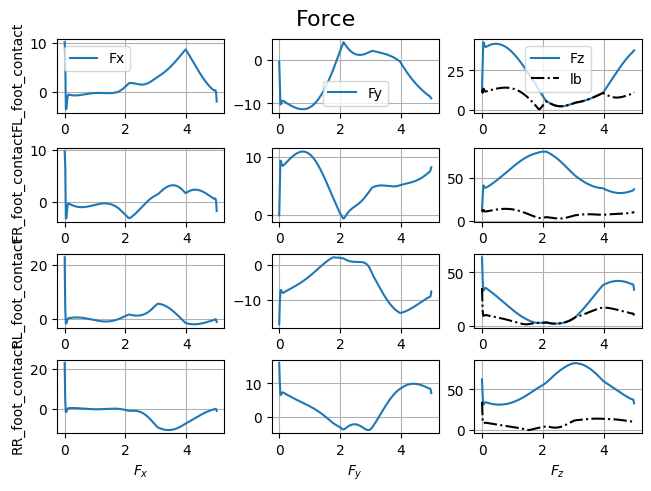

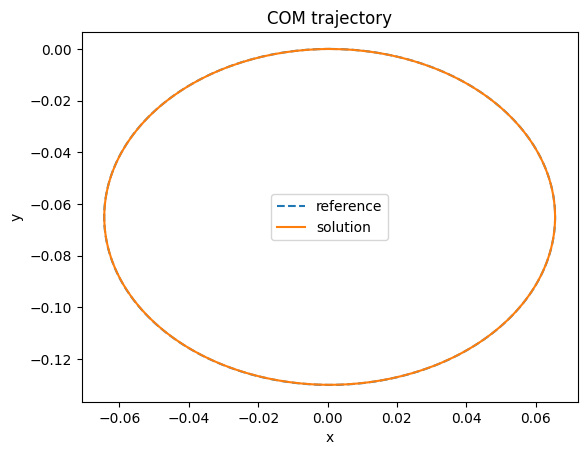

In [42]:
import matplotlib.pyplot as plt
constrained_sol = sol
time_lin = np.linspace(0, T, solver.problem.T)
fig, axs = plt.subplots(4, 3, constrained_layout=True)
for i, frame_idx in enumerate(supportFeetIds):
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    forces = np.array(constrained_sol[ct_frame_name])
    axs[i, 0].plot(time_lin, forces[:, 0], label="Fx")
    axs[i, 1].plot(time_lin, forces[:, 1], label="Fy")
    axs[i, 2].plot(time_lin, forces[:, 2], label="Fz")
    # Add friction cone constraints 
    Fz_lb = (1./MU)*np.sqrt(forces[:, 0]**2 + forces[:, 1]**2)
    # Fz_ub = np.zeros(time_lin.shape)
    # axs[i, 2].plot(time_lin, Fz_ub, 'k-.', label='ub')
    axs[i, 2].plot(time_lin, Fz_lb, 'k-.', label='lb')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].set_ylabel(ct_frame_name)
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()

axs[3, 0].set_xlabel(r"$F_x$")
axs[3, 1].set_xlabel(r"$F_y$")
axs[3, 2].set_xlabel(r"$F_z$")
fig.suptitle('Force', fontsize=16)


comDes = np.array(comDes)
centroidal_sol = np.array(constrained_sol['centroidal'])
plt.figure()
plt.plot(comDes[:, 0], comDes[:, 1], "--", label="reference")
plt.plot(centroidal_sol[:, 0], centroidal_sol[:, 1], label="solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("COM trajectory")
plt.show()

### Animate The Motion

In [2]:
from Go2Py.sim.mujoco import Go2Sim
robot_sim = Go2Sim()

In [70]:
import mujoco
import time
for i in range(len(xs)):
    q0 = xs[i][:19]
    qx = q0[3]
    qy = q0[4]
    qz = q0[5]
    qw = q0[6]
    q0[3:7] = [qw, qx, qy, qz]
    robot_sim.reset(q0)
    time.sleep(0.01)

In [71]:
from Go2Py.robot.model import Go2Model
model = Go2Model()

## With Arm

In [63]:
import pinocchio as pin
import crocoddyl
import pinocchio
import numpy as np
urdf_root_path = '/home/Go2py/Go2Py/assets'
urdf_path = '/home/Go2py/Go2Py/assets/urdf/go2_with_arm.urdf'
robot = pin.RobotWrapper.BuildFromURDF(
urdf_path, urdf_root_path, pin.JointModelFreeFlyer())

In [64]:
import sys
import mim_solvers
pinRef        = pin.LOCAL_WORLD_ALIGNED
FRICTION_CSTR = True
MU = 0.8     # friction coefficient

In [65]:
ee_frame_names = ['FL_FOOT', 'FR_FOOT', 'HL_FOOT', 'HR_FOOT', 'Link6']
rmodel = robot.model
rdata = robot.data
# # set contact frame_names and_indices
lfFootId = rmodel.getFrameId(ee_frame_names[0])
rfFootId = rmodel.getFrameId(ee_frame_names[1])
lhFootId = rmodel.getFrameId(ee_frame_names[2])
rhFootId = rmodel.getFrameId(ee_frame_names[3])
efId = rmodel.getFrameId(ee_frame_names[4])

In [66]:
q0 = np.array([0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.0] 
               +4*[0.0, 0.77832842, -1.56065452] + 8*[0.0]
                )
x0 =  np.concatenate([q0, np.zeros(rmodel.nv)])

In [69]:
pinocchio.forwardKinematics(rmodel, rdata, q0)
pinocchio.updateFramePlacements(rmodel, rdata)
rfFootPos0 = rdata.oMf[rfFootId].translation
rhFootPos0 = rdata.oMf[rhFootId].translation
lfFootPos0 = rdata.oMf[lfFootId].translation
lhFootPos0 = rdata.oMf[lhFootId].translation 
efPos0 = rdata.oMf[efId].translation

In [70]:
comRef = (rfFootPos0 + rhFootPos0 + lfFootPos0 + lhFootPos0) / 4
comRef[2] = pinocchio.centerOfMass(rmodel, rdata, q0)[2].item() 
print(f'The desired CoM position is: {comRef}')

The desired CoM position is: [0.00060515 0.         0.29477433]


In [71]:
supportFeetIds = [lfFootId, rfFootId, lhFootId, rhFootId]
supportFeePos = [lfFootPos0, rfFootPos0, lhFootPos0, rhFootPos0]

In [72]:
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
nu = actuation.nu

In [73]:
comDes = []

N_ocp = 250 #100
dt = 0.02
T = N_ocp * dt
radius = 0.065
for t in range(N_ocp+1):
    comDes_t = comRef.copy()
    w = (2 * np.pi) * 0.2 # / T
    comDes_t[0] += radius * np.sin(w * t * dt) 
    comDes_t[1] += radius * (np.cos(w * t * dt) - 1)
    comDes += [comDes_t]

In [74]:
import friction_utils
running_models = []
constraintModels = []

for t in range(N_ocp+1):
    contactModel = crocoddyl.ContactModelMultiple(state, nu)
    costModel = crocoddyl.CostModelSum(state, nu)

    # Add contact
    for frame_idx in supportFeetIds:
        support_contact = crocoddyl.ContactModel3D(state, frame_idx, np.array([0., 0., 0.]), pinRef, nu, np.array([0., 0.]))
        # print("contact name = ", rmodel.frames[frame_idx].name + "_contact")
        contactModel.addContact(rmodel.frames[frame_idx].name + "_contact", support_contact) 

    # Add state/control reg costs

    state_reg_weight, control_reg_weight = 1e-1, 1e-3

    freeFlyerQWeight = [0.]*3 + [500.]*3
    freeFlyerVWeight = [10.]*6
    legsQWeight = [0.01]*(rmodel.nv - 6)
    legsWWeights = [1.]*(rmodel.nv - 6)
    stateWeights = np.array(freeFlyerQWeight + legsQWeight + freeFlyerVWeight + legsWWeights)    


    stateResidual = crocoddyl.ResidualModelState(state, x0, nu)
    stateActivation = crocoddyl.ActivationModelWeightedQuad(stateWeights**2)
    stateReg = crocoddyl.CostModelResidual(state, stateActivation, stateResidual)

    if t == N_ocp:
        costModel.addCost("stateReg", stateReg, state_reg_weight*dt)
    else:
        costModel.addCost("stateReg", stateReg, state_reg_weight)

    if t != N_ocp:
        ctrlResidual = crocoddyl.ResidualModelControl(state, nu)
        ctrlReg = crocoddyl.CostModelResidual(state, ctrlResidual)
        costModel.addCost("ctrlReg", ctrlReg, control_reg_weight)      


    # Add COM task
    com_residual = crocoddyl.ResidualModelCoMPosition(state, comDes[t], nu)
    com_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    com_track = crocoddyl.CostModelResidual(state, com_activation, com_residual) # What does it correspond to exactly?
    if t == N_ocp:
        costModel.addCost("comTrack", com_track, 1e5)
    else:
        costModel.addCost("comTrack", com_track, 1e5)

    # End Effecor Position Task
    ef_residual = crocoddyl.ResidualModelFrameTranslation(state, efId, efPos0, nu)
    ef_activation = crocoddyl.ActivationModelWeightedQuad(np.array([1., 1., 1.]))
    ef_track = crocoddyl.CostModelResidual(state, ef_activation, ef_residual)
    if t == N_ocp:
        costModel.addCost("efTrack", ef_track, 1e5)
    else:
        costModel.addCost("efTrack", ef_track, 1e5)
        

    constraintModelManager = crocoddyl.ConstraintModelManager(state, actuation.nu)
    if(FRICTION_CSTR):
        if(t != N_ocp):
            for frame_idx in supportFeetIds:
                name = rmodel.frames[frame_idx].name + "_contact"
                residualFriction = friction_utils.ResidualFrictionCone(state, name, MU, actuation.nu)
                constraintFriction = crocoddyl.ConstraintModelResidual(state, residualFriction, np.array([0.]), np.array([np.inf]))
                constraintModelManager.addConstraint(name + "friction", constraintFriction)

    dmodel = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contactModel, costModel, constraintModelManager, 0., True)
    model = crocoddyl.IntegratedActionModelEuler(dmodel, dt)

    running_models += [model]


In [75]:
# Create shooting problem
ocp = crocoddyl.ShootingProblem(x0, running_models[:-1], running_models[-1])

solver = mim_solvers.SolverCSQP(ocp)
solver.max_qp_iters = 1000
max_iter = 500
solver.with_callbacks = True
solver.use_filter_line_search = False
solver.termination_tolerance = 1e-4
solver.eps_abs = 1e-6
solver.eps_rel = 1e-6

In [76]:
xs = [x0]*(solver.problem.T + 1)
us = solver.problem.quasiStatic([x0]*solver.problem.T) 
solver.solve(xs, us, max_iter)   

True

In [77]:
nq, nv, N = rmodel.nq, rmodel.nv, len(xs) 
jointPos_sol = []
jointVel_sol = []
jointAcc_sol = []
jointTorques_sol = []
centroidal_sol = []
xs, us = solver.xs, solver.us
x = []
for time_idx in range (N):
    q, v = xs[time_idx][:nq], xs[time_idx][nq:]
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.computeCentroidalMomentum(rmodel, rdata, q, v)
    centroidal_sol += [
        np.concatenate(
            [pin.centerOfMass(rmodel, rdata, q, v), np.array(rdata.hg.linear), np.array(rdata.hg.angular)]
            )
            ]
    jointPos_sol += [q]
    jointVel_sol += [v]
    x += [xs[time_idx]]
    if time_idx < N-1:
        jointAcc_sol +=  [solver.problem.runningDatas[time_idx].xnext[nq::]] 
        jointTorques_sol += [us[time_idx]]




sol = {'x':x, 'centroidal':centroidal_sol, 'jointPos':jointPos_sol, 
                    'jointVel':jointVel_sol, 'jointAcc':jointAcc_sol, 
                    'jointTorques':jointTorques_sol}       

for frame_idx in supportFeetIds:
    # print('extract foot id ', frame_idx, "_name = ", rmodel.frames[frame_idx].name)
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    datas = [solver.problem.runningDatas[i].differential.multibody.contacts.contacts[ct_frame_name] for i in range(N-1)]
    ee_forces = [datas[k].f.vector for k in range(N-1)] 
    sol[ct_frame_name] = [ee_forces[i] for i in range(N-1)]     
    

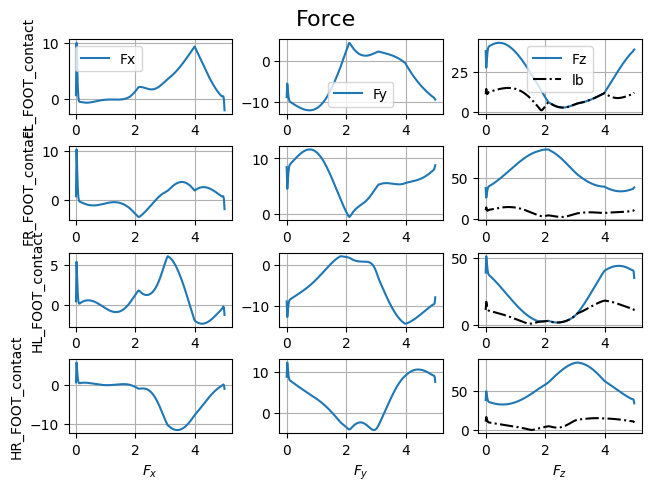

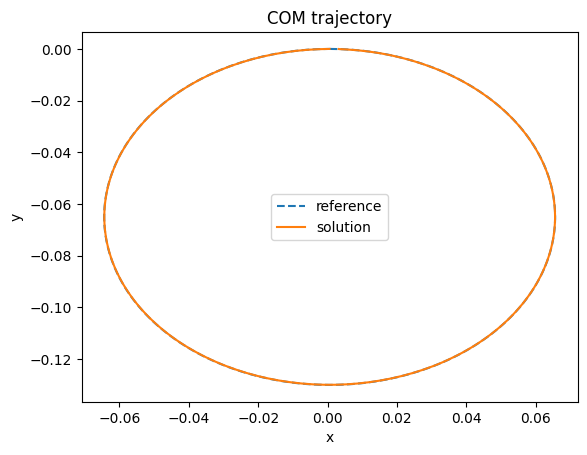

In [78]:
import matplotlib.pyplot as plt
constrained_sol = sol
time_lin = np.linspace(0, T, solver.problem.T)
fig, axs = plt.subplots(4, 3, constrained_layout=True)
for i, frame_idx in enumerate(supportFeetIds):
    ct_frame_name = rmodel.frames[frame_idx].name + "_contact"
    forces = np.array(constrained_sol[ct_frame_name])
    axs[i, 0].plot(time_lin, forces[:, 0], label="Fx")
    axs[i, 1].plot(time_lin, forces[:, 1], label="Fy")
    axs[i, 2].plot(time_lin, forces[:, 2], label="Fz")
    # Add friction cone constraints 
    Fz_lb = (1./MU)*np.sqrt(forces[:, 0]**2 + forces[:, 1]**2)
    # Fz_ub = np.zeros(time_lin.shape)
    # axs[i, 2].plot(time_lin, Fz_ub, 'k-.', label='ub')
    axs[i, 2].plot(time_lin, Fz_lb, 'k-.', label='lb')
    axs[i, 0].grid()
    axs[i, 1].grid()
    axs[i, 2].grid()
    axs[i, 0].set_ylabel(ct_frame_name)
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()

axs[3, 0].set_xlabel(r"$F_x$")
axs[3, 1].set_xlabel(r"$F_y$")
axs[3, 2].set_xlabel(r"$F_z$")
fig.suptitle('Force', fontsize=16)


comDes = np.array(comDes)
centroidal_sol = np.array(constrained_sol['centroidal'])
plt.figure()
plt.plot(comDes[:, 0], comDes[:, 1], "--", label="reference")
plt.plot(centroidal_sol[:, 0], centroidal_sol[:, 1], label="solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("COM trajectory")
plt.show()

In [111]:
mujoco_joint_names = \
['FL_hip_joint',
 'FL_thigh_joint',
 'FL_calf_joint',
 'FR_hip_joint',
 'FR_thigh_joint',
 'FR_calf_joint',
 'RL_hip_joint',
 'RL_thigh_joint',
 'RL_calf_joint',
 'RR_hip_joint',
 'RR_thigh_joint',
 'RR_calf_joint',
 'Joint1',
 'Joint2',
 'Joint3',
 'Joint4',
 'Joint5',
 'Joint6',
 'Joint7_1',
 'Joint7_2']

for joint_name in mujoco_joint_names:
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


Joint FL_hip_joint has id 4
Joint FL_thigh_joint has id 5
Joint FL_calf_joint has id 6
Joint FR_hip_joint has id 1
Joint FR_thigh_joint has id 2
Joint FR_calf_joint has id 3
Joint RL_hip_joint has id 10
Joint RL_thigh_joint has id 11
Joint RL_calf_joint has id 12
Joint RR_hip_joint has id 7
Joint RR_thigh_joint has id 8
Joint RR_calf_joint has id 9
Joint Joint1 has id 13
Joint Joint2 has id 14
Joint Joint3 has id 15
Joint Joint4 has id 16
Joint Joint5 has id 17
Joint Joint6 has id 18
Joint Joint7_1 has id 19
Joint Joint7_2 has id 20


In [112]:
pinocchio_joint_names = \
['FL_HAA_joint',
 'FL_HFE_joint',
 'FL_KFE_joint',
    'FR_HAA_joint',
    'FR_HFE_joint',
    'FR_KFE_joint',
    'HL_HAA_joint',
    'HL_HFE_joint',
    'HL_KFE_joint',
    'HR_HAA_joint',
    'HR_HFE_joint',
    'HR_KFE_joint',
    'Joint1',
    'Joint2',
    'Joint3',
    'Joint4',
    'Joint5',
    'Joint6',
    'Joint7_1',
    'Joint7_2']


for joint_name in pinocchio_joint_names:
    joint_id = rmodel.getJointId(joint_name)
    print(f'Joint {joint_name} has id {joint_id}')


Joint FL_HAA_joint has id 2
Joint FL_HFE_joint has id 3
Joint FL_KFE_joint has id 4
Joint FR_HAA_joint has id 5
Joint FR_HFE_joint has id 6
Joint FR_KFE_joint has id 7
Joint HL_HAA_joint has id 8
Joint HL_HFE_joint has id 9
Joint HL_KFE_joint has id 10
Joint HR_HAA_joint has id 11
Joint HR_HFE_joint has id 12
Joint HR_KFE_joint has id 13
Joint Joint1 has id 14
Joint Joint2 has id 15
Joint Joint3 has id 16
Joint Joint4 has id 17
Joint Joint5 has id 18
Joint Joint6 has id 19
Joint Joint7_1 has id 20
Joint Joint7_2 has id 21


In [116]:
pin_idx_to_mujoco_idx = []
for i in range(len(pinocchio_joint_names)):
    joint_name = pinocchio_joint_names[i]
    pin_joint_id = rmodel.getJointId(joint_name)
    mujoco_joint_name = mujoco_joint_names[i]
    mujoco_joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, mujoco_joint_name)
    pin_idx_to_mujoco_idx.append(mujoco_joint_id)

pin_idx_to_mujoco_idx = np.array(pin_idx_to_mujoco_idx) - min(pin_idx_to_mujoco_idx)

In [ ]:
import mujoco
model = mujoco.MjModel.from_xml_path('/home/Go2py/Go2Py/assets/mujoco/go2_with_arm.xml')
data = mujoco.MjData(model)
viewer = mujoco.viewer.launch_passive(model, data)

In [118]:
import time
for k in range(1000):
    i = k % len(xs)
    q0 = xs[i][:27]
    qx = q0[3]
    qy = q0[4]
    qz = q0[5]
    qw = q0[6]
    q0[3:7] = [qw, qx, qy, qz]
    q0[7:] = q0[7:][pin_idx_to_mujoco_idx]
    data.qpos[:] = q0

    mujoco.mj_step(model, data)
    viewer.sync()
    time.sleep(1/60)